In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from smt.surrogate_models import KRG
from juliacall import Main as jl
from mpl_toolkits.mplot3d import Axes3D
# import plotly.graph_objs as go

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [3]:
### CREATE DATA ARRAY ###

# Load the Julia file
jl.include("c:/Users/wongj_rl8z6/FlowLab/XFoil/write_xfoil.jl")

# Potential families of files to choose from
one_file = ["naca0012.dat"]
camber_files = ["naca0012.dat", "naca2412.dat", "naca4412.dat"]
thickness_files = ["naca0009.dat", "naca0012.dat", "naca0015.dat", "naca0018.dat"]

# Select which files to use
list_of_files =  thickness_files

# Set parameters
alpha = list(range(-16, 20, 1))  # range of angle of attacks, in degrees
re = 1e5

# Convert Python list to Julia array
julia_list_of_files = jl.convert(jl.Array, list_of_files)
julia_alpha = jl.convert(jl.Array, [float(a) for a in alpha])

# Get data from julia
julia_data = jl.process_files(julia_list_of_files, julia_alpha, re)

# Create numpy array from julia data, make sure type is float
data_array = np.array(julia_data, dtype=float)

columns = {
    "alpha": 0,
    "c_l": 1,
    "c_d": 2,
    "c_dp": 3,
    "c_m": 4,
    "converged": 5,
    "camber": 6,
    "thickness": 7
}

# Access data using column names
alpha_values = data_array[:, columns["alpha"]]
c_l_values = data_array[:, columns["c_l"]]
c_d_values = data_array[:, columns["c_d"]]
c_dp_values = data_array[:, columns["c_dp"]]
c_m_values = data_array[:, columns["c_m"]]
converged_values = data_array[:, columns["converged"]]
camber_values = data_array[:, columns["camber"]]
thickness_values = data_array[:, columns["thickness"]]

print(thickness_values)

    

[ 9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.  9.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]


___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 144
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  4.9797397
[ 9.          9.09090909  9.18181818  9.27272727  9.36363636  9.45454545
  9.54545455  9.63636364  9.72727273  9.81818182  9.90909091 10.
 10.09090909 10.18181818 10.27272727 10.36363636 10.45454545 10.54545455
 10.63636364 10.72727273 10.81818182 10.90909091 11.         11.09090909
 11.18181818 11.27272727 11.36363636 11.45454545 11.54545455 11.63636364
 11.72727273 11.81818182 11.90909091 12.         12.09090909 12.18181818
 12.27272727 12.36363636 12.45454545 12.54545455 12.63636364 12.72727273
 12.81818182 12.90909091 13.         13.09090909 13.18181818 13.27272727
 13.36363

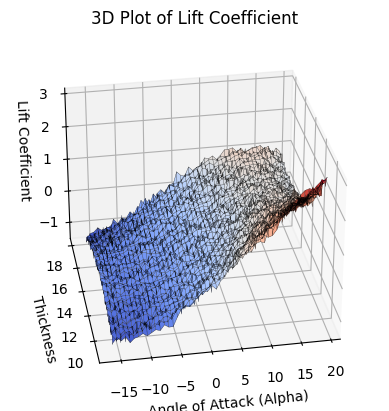

In [6]:
### CHOOSE LIFT, DRAG, OR MOMENT COEFFICIENT ###

# Choose which coefficient to plot
focus = "lift"  # "lift", "drag", or "moment"

# Create inputs (xt) for alpha and thickness plot # attempt thickness
xt = np.column_stack((alpha_values, thickness_values))

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


alpha_min = min(alpha_values)
alpha_max = max(alpha_values)
camber_min = min(camber_values)
camber_max = max(camber_values)
thickness_min = min(thickness_values)
thickness_max = max(thickness_values)

### CREATE MODEL ###

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha = np.linspace(alpha_min, alpha_max, 50)
thickness = np.linspace(thickness_min, thickness_max, 100)
print(thickness)
alpha_grid, thickness_grid = np.meshgrid(alpha, thickness)
xt_grid = np.c_[alpha_grid.ravel(), thickness_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

### PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, thickness_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, thickness_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Thickness')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=30, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 144
   
___________________________________________________________________________
   
 Training
   
   Training ...


c:\Users\wongj_rl8z6\AppData\Local\Programs\Python\Python311\Lib\site-packages\smt\surrogate_models\krg_based.py:532: UserWarning: Warning: multiple x input features have the same value (at least same row twice).
  warnings.warn(


   Training - done. Time (sec):  2.1872499
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0209389
   
   Prediction time/pt. (sec) :  0.0000084
   


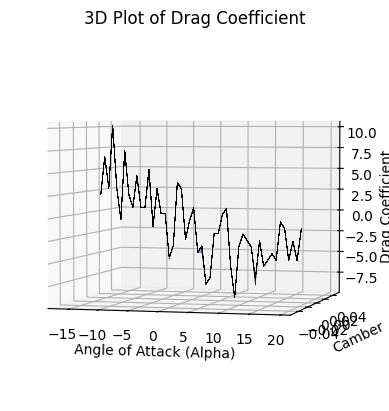

In [5]:
### CHOOSE DRAG COEFFICIENT ###

# Choose which coefficient to plot
focus = "drag"  # "lift", "drag", or "moment"

# Create inputs (xt) for alpha and camber plot # attempt thickness
xt = np.column_stack((alpha_values, camber_values))

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


alpha_min = min(alpha_values)
alpha_max = max(alpha_values)
camber_min = min(camber_values)
camber_max = max(camber_values)
thickness_min = min(thickness_values)
thickness_max = max(thickness_values)

### CREATE MODEL ###

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha = np.linspace(alpha_min, alpha_max, 50)
camber = np.linspace(camber_min, camber_max, 50)
alpha_grid, camber_grid = np.meshgrid(alpha, camber)
xt_grid = np.c_[alpha_grid.ravel(), camber_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

### PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, camber_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, camber_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=3, azim=285)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 108
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  1.9812977
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0260062
   
   Prediction time/pt. (sec) :  0.0000104
   


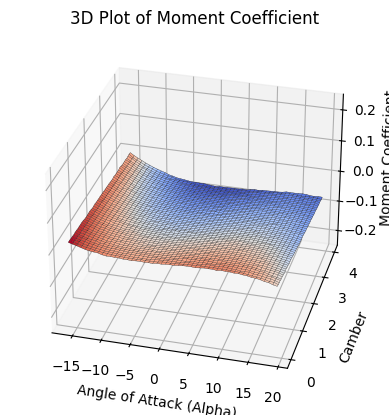

In [28]:
### CHOOSE MOMENT COEFFICIENT ###

# Choose which coefficient to plot
focus = "moment"  # "lift", "drag", or "moment"

# Create inputs (xt) for alpha and camber plot # attempt thickness
xt = np.column_stack((alpha_values, camber_values))

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


alpha_min = min(alpha_values)
alpha_max = max(alpha_values)
camber_min = min(camber_values)
camber_max = max(camber_values)
thickness_min = min(thickness_values)
thickness_max = max(thickness_values)

### CREATE MODEL ###

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha = np.linspace(alpha_min, alpha_max, 50)
camber = np.linspace(camber_min, camber_max, 50)
alpha_grid, camber_grid = np.meshgrid(alpha, camber)
xt_grid = np.c_[alpha_grid.ravel(), camber_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

### PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, camber_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, camber_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=30, azim=285)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

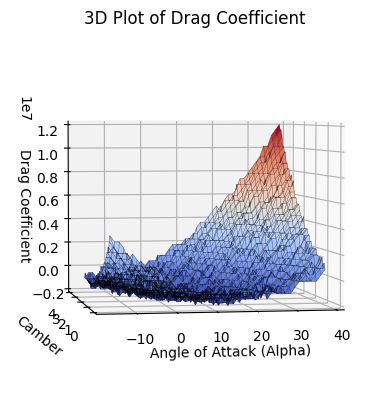

In [ ]:
### JUST PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, camber_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, camber_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=3, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

In [ ]:
### CHOOSE LIFT, DRAG, OR MOMENT COEFFICIENT ### TRY WITH OTHER DIM

# Choose which coefficient to plot
focus = "lift"  # "lift", "drag", or "moment"

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


# Create inputs (xt) for alpha and camber plot
other_dim = "camber" # "camber" or "thickness"

if other_dim == "camber":
    second_dim = camber_values
elif other_dim == "thickness":
    second_dim = thickness_values

xt = np.column_stack((alpha_values, second_dim))
# print(xt)

[[-10.   0.]
 [ -8.   0.]
 [ -6.   0.]
 [ -4.   0.]
 [ -2.   0.]
 [  0.   0.]
 [  2.   0.]
 [  4.   0.]
 [  6.   0.]
 [  8.   0.]
 [ 10.   0.]
 [ 12.   0.]
 [ 14.   0.]
 [-10.   2.]
 [ -8.   2.]
 [ -6.   2.]
 [ -4.   2.]
 [ -2.   2.]
 [  0.   2.]
 [  2.   2.]
 [  4.   2.]
 [  6.   2.]
 [  8.   2.]
 [ 10.   2.]
 [ 12.   2.]
 [ 14.   2.]
 [-10.   4.]
 [ -8.   4.]
 [ -6.   4.]
 [ -4.   4.]
 [ -2.   4.]
 [  0.   4.]
 [  2.   4.]
 [  4.   4.]
 [  6.   4.]
 [  8.   4.]
 [ 10.   4.]
 [ 12.   4.]
 [ 14.   4.]]


In [ ]:
### CREATE MODEL ###  TRY SECOND DIM

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()
print(min(second_dim))
print(max(second_dim))

# Create grid for prediction
alpha = np.linspace(min(alpha_values), min(alpha_values), 50)
second_dim = np.linspace(min(second_dim), max(second_dim), 50)
alpha_grid, second_dim_grid = np.meshgrid(alpha, second_dim)
xt_grid = np.c_[alpha_grid.ravel(), second_dim_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 39
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  2.1276968
0.0
4.0
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0181251
   
   Prediction time/pt. (sec) :  0.0000073
   


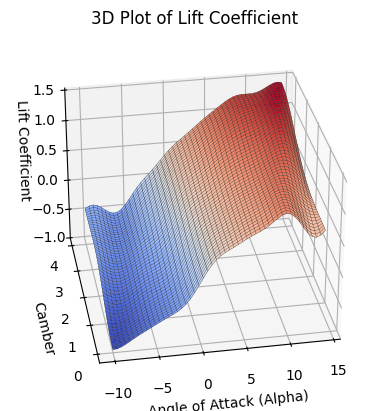

In [ ]:
### PLOT MODEL W/O INTERACTIVE ### copy

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, camber_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, camber_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=30, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

In [ ]:
### CREATE INTERACTIVE PLOTS ###

# Create the surface plot
surface = go.Surface(
    x=alpha_grid,
    y=camber_grid,
    z=yt_grid,
    colorscale='Viridis'
)

# Create the layout
layout = go.Layout(
    title='Interactive 3D Plot of Lift Coefficient',
    scene=dict(
        xaxis_title='Angle of Attack (Alpha)',
        yaxis_title='Camber',
        zaxis_title='Lift Coefficient'
    )
)

# Create the figure
fig = go.Figure(data=[surface], layout=layout)

# Show the plot
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

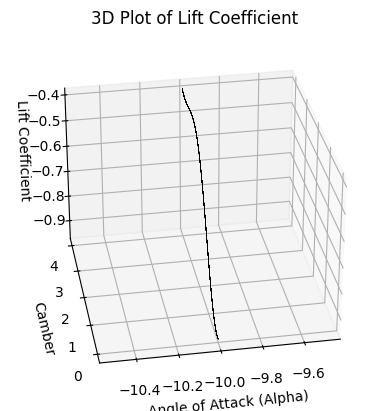

In [ ]:
### PLOT MODEL W/O INTERACTIVE ### with second_dim_grid

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, second_dim_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, second_dim_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=30, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()